In [10]:
import pandas as pd
import ast
from itertools import combinations
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")



In [8]:
df = pd.read_csv(
    "../dataset/processed/transactions_context.csv"
)

df.head()


,order_id,user_id,products,order_dow,order_hour,is_weekend,time_bucket,context_label,days_since_prior_order
0,2539329,1,"[196, 14084, 12427, 26088, 26405]",2,8,0,morning,Weekday_Morning,NaN
1,2398795,1,"[196, 10258, 12427, 13176, 26088, 13032]",3,7,0,morning,Weekday_Morning,15.0
2,473747,1,"[196, 12427, 10258, 25133, 30450]",3,12,0,afternoon,Weekday_Afternoon,21.0
3,2254736,1,"[196, 12427, 10258, 25133, 26405]",4,7,0,morning,Weekday_Morning,29.0
4,431534,1,"[196, 12427, 10258, 25133, 10326, 17122, 41787...",4,15,0,afternoon,Weekday_Afternoon,28.0


In [11]:
df["products"] = df["products"].apply(ast.literal_eval)

df["products"].head()


0                    [196, 14084, 12427, 26088, 26405]
1             [196, 10258, 12427, 13176, 26088, 13032]
2                    [196, 12427, 10258, 25133, 30450]
3                    [196, 12427, 10258, 25133, 26405]
4    [196, 12427, 10258, 25133, 10326, 17122, 41787...
Name: products, dtype: object

In [12]:
df = df[df["products"].apply(len) >= 2]

print("Orders:", df.shape[0])



Orders: 3182490


In [ ]:
TOP_K = 1000   

product_counter = Counter()

for items in df["products"]:
    for p in items:
        product_counter[p] += 1

top_products = set(
    p for p, _ in product_counter.most_common(TOP_K)
)

df["products"] = df["products"].apply(
    lambda x: [p for p in x if p in top_products]
)

df = df[df["products"].apply(len) >= 2]

print("Remaining orders:", df.shape[0])


Remaining orders: 2661954


In [14]:
item_counter = Counter()
pair_counter = Counter()

for items in df["products"]:
    unique_items = sorted(set(items))
    
    for p in unique_items:
        item_counter[p] += 1
        
    for a, b in combinations(unique_items, 2):
        pair_counter[(a, b)] += 1

num_orders = len(df)


In [15]:
MIN_SUPPORT = 0.001
MIN_CONFIDENCE = 0.2
MIN_LIFT = 1.2

rules = []

for (a, b), pair_cnt in pair_counter.items():
    support = pair_cnt / num_orders
    
    conf_a_b = pair_cnt / item_counter[a]
    conf_b_a = pair_cnt / item_counter[b]
    
    lift = conf_a_b / (item_counter[b] / num_orders)
    
    if support >= MIN_SUPPORT and lift >= MIN_LIFT:
        rules.append({
            "antecedent": a,
            "consequent": b,
            "support": support,
            "confidence": conf_a_b,
            "lift": lift
        })

rules_df = pd.DataFrame(rules)

rules_df.sort_values(
    ["lift", "confidence"],
    ascending=False
).head(10)


,antecedent,consequent,support,confidence,lift
1783,4962,38544,0.001083,0.465450,191.145889
1588,23296,44156,0.001076,0.441480,151.384820
295,33548,44156,0.001038,0.351930,120.677656
40,40198,46886,0.001143,0.298557,91.984458
2106,12576,39947,0.001237,0.348097,80.463605
16,19156,22124,0.001024,0.370029,78.850373
39,17758,40198,0.001116,0.287275,75.052835
1288,36316,47977,0.001307,0.371490,68.648955
2133,18926,22124,0.001173,0.310160,66.092810
312,13263,28465,0.001538,0.454687,60.972010


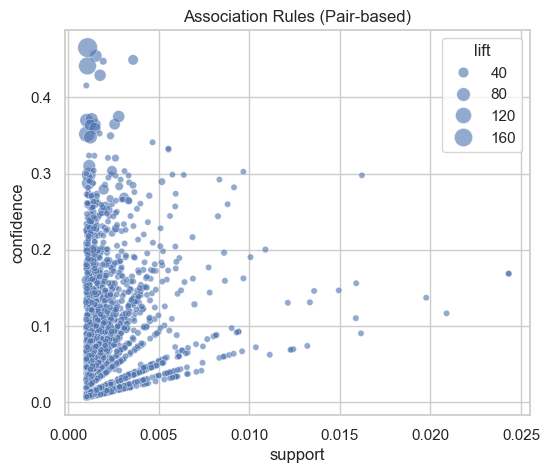

In [16]:
plt.figure(figsize=(6,5))

sns.scatterplot(
    data=rules_df,
    x="support",
    y="confidence",
    size="lift",
    sizes=(20,200),
    alpha=0.6
)

plt.title("Association Rules (Pair-based)")
plt.show()


In [17]:
context_rules = {}

for ctx, sub_df in df.groupby("context_label"):
    if len(sub_df) < 1000:
        continue
        
    pair_counter = Counter()
    item_counter = Counter()

    for items in sub_df["products"]:
        items = set(items)
        for p in items:
            item_counter[p] += 1
        for a, b in combinations(sorted(items), 2):
            pair_counter[(a, b)] += 1

    rules_ctx = []
    for (a, b), cnt in pair_counter.items():
        support = cnt / len(sub_df)
        lift = (cnt / item_counter[a]) / (item_counter[b] / len(sub_df))
        if support >= 0.002 and lift >= 1.2:
            rules_ctx.append((a, b, support, lift))

    context_rules[ctx] = rules_ctx

print("Contexts mined:", context_rules.keys())


Contexts mined: dict_keys(['Weekday_Afternoon', 'Weekday_Evening', 'Weekday_Morning', 'Weekday_Night', 'Weekend_Afternoon', 'Weekend_Evening', 'Weekend_Morning', 'Weekend_Night'])
